In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

In [2]:
participation = pd.read_csv("data/users_participating_events.csv")

In [3]:
participation.head()

,user_facebook_id,rsvp_status,event_facebook_id
0,201098027006232,attending,1606969096264134
1,334566996897353,attending,1606969096264134
2,354393944896674,attending,1606969096264134
3,1698350500494930,attending,1606969096264134
4,1775177359410467,attending,1606969096264134


In [4]:
events = pd.read_csv("data/events.csv", index_col='facebook_id')
events = events.loc[:, ['attending_count', 'facebook_page', 'name', 'place_name', 'owner_id', 'owner_name']]

In [5]:
participation.head()

,user_facebook_id,rsvp_status,event_facebook_id
0,201098027006232,attending,1606969096264134
1,334566996897353,attending,1606969096264134
2,354393944896674,attending,1606969096264134
3,1698350500494930,attending,1606969096264134
4,1775177359410467,attending,1606969096264134


In [6]:
participation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3667328 entries, 0 to 3667327
Data columns (total 3 columns):
user_facebook_id     int64
rsvp_status          object
event_facebook_id    int64
dtypes: int64(2), object(1)
memory usage: 83.9+ MB


In [10]:
# attending and maybe
attending = participation.loc[lambda df: df.rsvp_status.isin(['attending', 'maybe']),
                              ['user_facebook_id', 'event_facebook_id']]

In [11]:
# data cleaning stuff, as some are only in one (consult `1_coinccidenses_exploration`)
common_indices = set(events.index).intersection(set(attending['event_facebook_id']))
attending = attending.loc[lambda df: df['event_facebook_id'].isin(common_indices)]

In [12]:
attending.head()

,user_facebook_id,event_facebook_id
0,201098027006232,1606969096264134
1,334566996897353,1606969096264134
2,354393944896674,1606969096264134
3,1698350500494930,1606969096264134
4,1775177359410467,1606969096264134


## Places

In [21]:
place_names = events[['place_name']].dropna()
place_names.head()

,place_name
facebook_id,
1000321563316078,Galeria Sztuki Współczesnej BWA w Katowicach
1000519489971322,Kinoteatr Rialto
1000566356639241,Miejski Dom Kultury Koszutka
1001073743249429,Bookszpan Katowice
1001137926666751,Kontenery Kultury


In [83]:
attending_place = attending.merge(place_names, left_on='event_facebook_id', right_index=True)

In [84]:
attending_place.shape

(1140789, 3)

In [119]:
# to remove multiple occurences of the same person
# I need to decide if I do that or not
# right now I assume that each person for each organization counts only once
attending_place = attending_place.groupby(['user_facebook_id', 'place_name']).first().reset_index()

In [86]:
attending_place.shape

(872019, 3)

In [88]:
attending_place.head()

,user_facebook_id,place_name,event_facebook_id
0,513945594052,Berghain / Panorama Bar,248364438837173
1,513945594052,Muzeum Śląskie,169398046731346
2,527755624742,KATO,398972300144397
3,527755624742,Katowice Centrum,1630667683847672
4,527755624742,Katowice Rynek,389240287866795


In [89]:
counts_place = attending_place.groupby('place_name').size().to_frame().rename(columns={0: 'count'})

In [100]:
counts_place.head(10)

,count
place_name,
-A-R-C-H-I-B-A-R-,1344
3 Stawy Katowice,8
AEGEE-Katowice,68
ANNA NOCON health & beauty,39
ASP w Katowicach,2770
Absurdalna,783
Akademia Muzyczna W Katowicach,1336
Akademia Muzyczna im. Karola Szymanowskiego w Katowicach,326
Aleja Korfantego,38


In [101]:
len(counts_place)

420

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e824438>]], dtype=object)

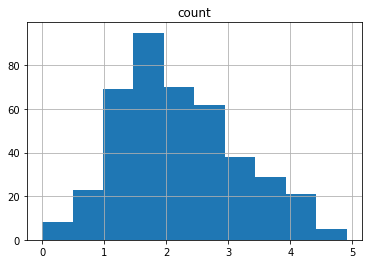

In [102]:
np.log10(counts_place).hist()

In [103]:
pairs_raw = attending_place.merge(attending_place, on='user_facebook_id')

In [104]:
pairs_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6155771 entries, 0 to 6155770
Data columns (total 5 columns):
user_facebook_id       int64
place_name_x           object
event_facebook_id_x    int64
place_name_y           object
event_facebook_id_y    int64
dtypes: int64(3), object(2)
memory usage: 281.8+ MB


In [109]:
pairs = pairs_raw.groupby(['place_name_x', 'place_name_y']).size() \
  .reset_index().rename(columns={0: 'count'})

In [110]:
pairs = pairs \
  .merge(counts_place, left_on='place_name_x', right_index=True, suffixes=['', '_x']) \
  .merge(counts_place, left_on='place_name_y', right_index=True, suffixes=['', '_y'])

In [111]:
n_users = len(set(attending_place['user_facebook_id']))
n_users

419787

In [112]:
pairs['pmi'] = np.log(n_users * pairs['count'] / (pairs['count_x'] * pairs['count_y']))

In [113]:
# is it correct? or jsut because matrix is sparse I miss 'zeros'?
pairs['pmi'].describe()

count    91980.000000
mean         2.893693
std          1.921265
min         -4.462894
25%          1.701430
50%          2.850259
75%          3.951126
max         12.947503
Name: pmi, dtype: float64

In [114]:
pairs.shape

(91980, 6)

In [115]:
pairs.loc[lambda df: df['count'] > 1].shape

(71152, 6)

In [116]:
pairs.loc[lambda df: df['count'] > 2].shape

(60099, 6)

In [117]:
pairs.head()

,place_name_x,place_name_y,count,count_x,count_y,pmi
0,-A-R-C-H-I-B-A-R-,-A-R-C-H-I-B-A-R-,1344,1344,1344,5.744097
409,AEGEE-Katowice,-A-R-C-H-I-B-A-R-,1,68,1344,1.524589
522,ANNA NOCON health & beauty,-A-R-C-H-I-B-A-R-,3,39,1344,3.179148
692,ASP w Katowicach,-A-R-C-H-I-B-A-R-,151,2770,1344,2.834774
1072,Absurdalna,-A-R-C-H-I-B-A-R-,34,783,1344,2.607325


In [118]:
pairs.to_csv("data/processed/pair_count_maybe_place.csv", index=False)

## Owners

In [136]:
owner_names = events[['owner_name']].dropna()
owner_names.head()

,owner_name
facebook_id,
1000321563316078,Galeria Sztuki Współczesnej BWA w Katowicach
1000474419998733,"MDK ""Południe"" w Katowicach"
1000519489971322,Kinoteatr Rialto
1000566356639241,Miejski Dom Kultury Koszutka
1001073743249429,Bookszpan Katowice


In [137]:
attending_owner = attending.merge(owner_names, left_on='event_facebook_id', right_index=True)

In [138]:
# to remove multiple occurences of the same person
# I need to decide if I do that or not
# right now I assume that each person for each organization counts only once
attending_owner = attending_owner.groupby(['user_facebook_id', 'owner_name']).first().reset_index()

In [139]:
counts_owner = attending_owner.groupby('owner_name').size().to_frame().rename(columns={0: 'count'})

In [140]:
counts_owner.head(10)

,count
owner_name,
"""Camerata Silesia"" Zespół Śpiewaków Miasta Katowice",759
"""eM Band""",158
-A-R-C-H-I-B-A-R-,1515
1st Year Students Drawing Studio - ASP Katowice,4
4 Design Days,5414
A<24,1166
AEGEE-Katowice,905
ANIMATOR,103
ARCHIKIDS Katowice,551


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x103b96e48>]], dtype=object)

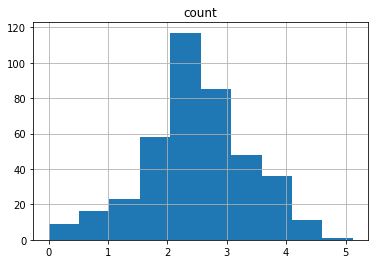

In [141]:
np.log10(counts_owner).hist()

In [142]:
len(counts_owner)

404

In [157]:
pairs_raw = attending_owner.merge(attending_owner, on='user_facebook_id')

In [158]:
pairs = pairs_raw.groupby(['owner_name_x', 'owner_name_y']).size() \
  .reset_index().rename(columns={0: 'count'})

In [159]:
pairs = pairs \
  .merge(counts_owner, left_on='owner_name_x', right_index=True, suffixes=['', '_x']) \
  .merge(counts_owner, left_on='owner_name_y', right_index=True, suffixes=['', '_y'])

In [160]:
n_users = len(set(attending_owner['user_facebook_id']))
n_users

401626

In [161]:
pairs['pmi'] = np.log(n_users * pairs['count'] / (pairs['count_x'] * pairs['count_y']))

In [162]:
# is it correct? or jsut because matrix is sparse I miss 'zeros'?
pairs['pmi'].describe()

count    108960.000000
mean          2.388154
std           1.552885
min          -4.680584
25%           1.474338
50%           2.503359
75%           3.402899
max          12.903277
Name: pmi, dtype: float64

In [163]:
pairs.shape

(108960, 6)

In [164]:
pairs.head()

,owner_name_x,owner_name_y,count,count_x,count_y,pmi
0,"""Camerata Silesia"" Zespół Śpiewaków Miasta Kat...","""Camerata Silesia"" Zespół Śpiewaków Miasta Kat...",759,759,759,6.271275
328,"""eM Band""","""Camerata Silesia"" Zespół Śpiewaków Miasta Kat...",11,158,759,3.606575
509,-A-R-C-H-I-B-A-R-,"""Camerata Silesia"" Zespół Śpiewaków Miasta Kat...",16,1515,759,1.720693
887,4 Design Days,"""Camerata Silesia"" Zespół Śpiewaków Miasta Kat...",18,5414,759,0.564903
1255,A<24,"""Camerata Silesia"" Zespół Śpiewaków Miasta Kat...",6,1166,759,1.001700


In [165]:
pairs.to_csv("data/processed/pair_count_maybe_owner.csv", index=False)